In [1]:
cd /kaggle/input/

/kaggle/input


In [2]:
import pandas as pd
import numpy as np
import keras
import matplotlib.pyplot as plt
import os

Using TensorFlow backend.


In [3]:
from glob import glob
from keras.preprocessing.image import load_img, img_to_array

In [4]:
files = glob('/kaggle/input/breast-histopathology-images/*/*/*')

In [5]:
count =0 
for file in files:
    if file[-5] == '1':
        count+=1
print(count)

78838


In [6]:
len(files)

278082

In [7]:
def show_img(files):
    plt.figure(figsize= (10,10))
    ind = np.random.randint(0, len(files), 25)
    i=0
    for loc in ind:
        plt.subplot(5,5,i+1)
        sample = load_img(files[loc], target_size=(150,150))
        sample = img_to_array(sample)
        plt.axis("off")
        plt.imshow(sample.astype("uint8"))
        i+=1

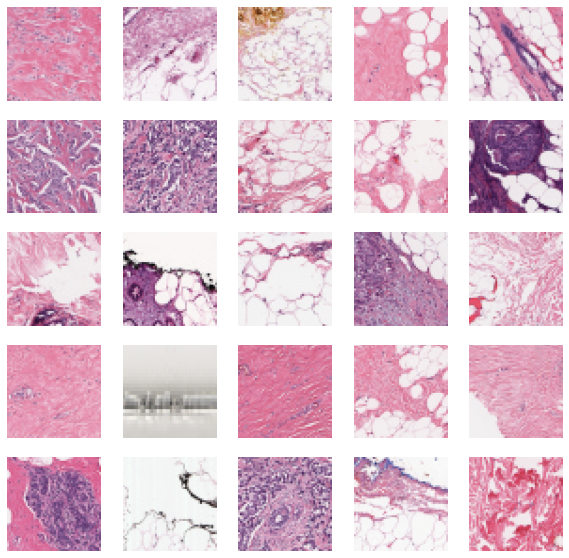

In [8]:
show_img(files)

In [9]:
def load_data(files, lower_limit, upper_limit):
    X = []
    y = []
    for file in files[lower_limit:upper_limit]:
        if file.endswith(".png"):
            img = load_img(file, target_size = (50,50))
            pixels = img_to_array(img)
            pixels /= 255
            X.append(pixels)
            if(file[-5] == '1'):
                y.append(1)
            elif(file[-5] == '0'):
                y.append(0)
    return np.stack(X), y
        
    

In [10]:
X_train,y_train = load_data(files,0, 90000)

In [11]:
import seaborn as sns

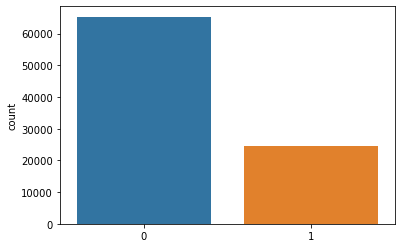

In [12]:
sns.countplot(y_train)

In [13]:
X_test, y_test = load_data(files, 90000, 110000)

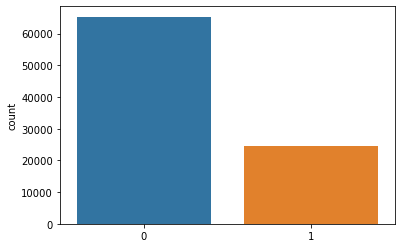

In [14]:
sns.countplot(y_train)

## Handling Class Imbalance Problem 

In [15]:
files[:5]

['/kaggle/input/breast-histopathology-images/10295/0/10295_idx5_x1351_y1101_class0.png',
 '/kaggle/input/breast-histopathology-images/10295/0/10295_idx5_x1501_y501_class0.png',
 '/kaggle/input/breast-histopathology-images/10295/0/10295_idx5_x1501_y1101_class0.png',
 '/kaggle/input/breast-histopathology-images/10295/0/10295_idx5_x451_y901_class0.png',
 '/kaggle/input/breast-histopathology-images/10295/0/10295_idx5_x801_y451_class0.png']

In [16]:
def load_balanced_data(files, size, start_index):
    half_size = int(size/2)
    count=0
    res = []
    y = []
    for file in files[start_index:]:
        if (count!=half_size):
            if file[-5] == '1' and file.endswith(".png"):
                img = load_img(file, target_size = (50,50))
                pixels = img_to_array(img)
                pixels /= 255
                res.append(pixels)
                y.append(1)
                count += 1
                
    for file in files[start_index:]:
        if(count!=0):
            if(file[-5] == '0'):
                img = load_img(file, target_size = (50,50))
                pixels = img_to_array(img)
                pixels /= 255
                res.append(pixels)
                y.append(0)
                count -= 1
    return np.stack(res), y
    
            

In [17]:
X_train2, y_train2 = load_balanced_data(files, 90000,0)

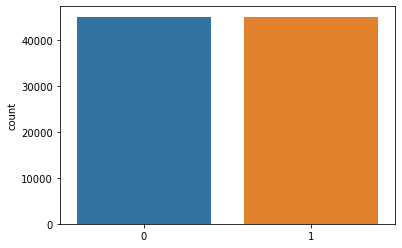

In [18]:
sns.countplot(y_train2)

In [19]:
x_test2, y_test2 = load_balanced_data(files, 20000, 100000)

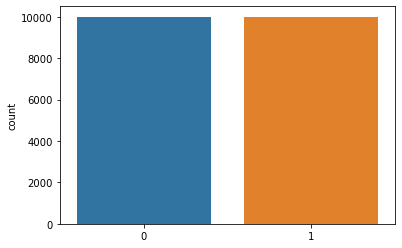

In [20]:
sns.countplot(y_test2)

In [22]:
from keras.models import Model
from keras.layers import Input, Dense, Dropout, Conv2D, Activation, MaxPooling2D, Flatten, BatchNormalization

In [23]:
def def_model(inp_shape = (50,50,3)):
    inp = Input(inp_shape)
    m = Conv2D(32, (3,3), kernel_initializer='he_uniform', padding="same", activation='relu')(inp)
    m = MaxPooling2D(2)(m)
    m = BatchNormalization()(m)
    m = Conv2D(64, (3,3), kernel_initializer='he_uniform', padding="same", activation='relu')(m)
    m = MaxPooling2D(2)(m)
    m = BatchNormalization()(m)
    m = Conv2D(128, (3,3), kernel_initializer='he_uniform', padding="same", activation='relu')(m)
    m = MaxPooling2D(2)(m)
    m = BatchNormalization()(m)
    m = Conv2D(128, (3,3), kernel_initializer='he_uniform', padding="same", activation='relu')(m)
    m = MaxPooling2D(2)(m)
    m = Flatten()(m)
    m = Dense(128, activation = "relu")(m)
    out = Dense(1, activation = "sigmoid")(m)
    model = Model(inp, out)
    model.compile(optimizer = keras.optimizers.SGD(1e-3, momentum=0.9), loss="binary_crossentropy", metrics = ['acc'])
    return model

In [24]:
model = def_model()

In [25]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 50, 50, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 25, 25, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 25, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 12, 12, 64)        256 

In [26]:
history = model.fit(X_train2, y_train2, validation_data=(x_test2, y_test2), epochs = 25, batch_size=256)

Train on 90000 samples, validate on 20000 samples
Epoch 1/25
90000/90000 [==============================] - 284s 3ms/step - loss: 0.4470 - acc: 0.8003 - val_loss: 0.4094 - val_acc: 0.8361
Epoch 2/25
90000/90000 [==============================] - 289s 3ms/step - loss: 0.3907 - acc: 0.8286 - val_loss: 0.3537 - val_acc: 0.8546
Epoch 3/25
90000/90000 [==============================] - 295s 3ms/step - loss: 0.3731 - acc: 0.8368 - val_loss: 0.3430 - val_acc: 0.8584
Epoch 4/25
90000/90000 [==============================] - 292s 3ms/step - loss: 0.3616 - acc: 0.8431 - val_loss: 0.3355 - val_acc: 0.8621
Epoch 5/25
90000/90000 [==============================] - 285s 3ms/step - loss: 0.3528 - acc: 0.8478 - val_loss: 0.3257 - val_acc: 0.8641
Epoch 6/25
90000/90000 [==============================] - 287s 3ms/step - loss: 0.3424 - acc: 0.8512 - val_loss: 0.3199 - val_acc: 0.8672
Epoch 7/25
90000/90000 [==============================] - 284s 3ms/step - loss: 0.3352 - acc: 0.8553 - val_loss: 0.3974 - 

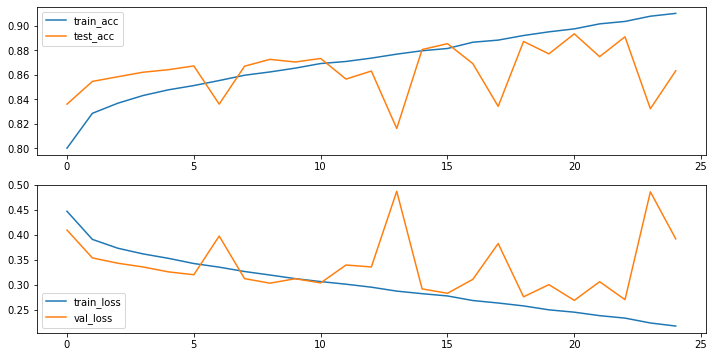

In [27]:
plt.figure(figsize = (12,6))
plt.subplot(2,1,1)
plt.plot(history.history['acc'], label="train_acc")
plt.plot(history.history['val_acc'], label = "test_acc")
plt.legend()
plt.subplot(2,1,2)
plt.plot(history.history['loss'], label = "train_loss")
plt.plot(history.history['val_loss'], label = "val_loss")
plt.legend()

## Trying Dropout and Data Augmentation 

In [28]:
def def_model2(inp_shape = (50,50,3)):
    inp = Input(inp_shape)
    m = Conv2D(32, (3,3), kernel_initializer='he_uniform', padding="same", activation='relu')(inp)
    m = MaxPooling2D(2)(m)
    m = Conv2D(64, (3,3), kernel_initializer='he_uniform', padding="same", activation='relu')(m)
    m = MaxPooling2D(2)(m)
    m = Conv2D(128, (3,3), kernel_initializer='he_uniform', padding="same", activation='relu')(m)
    m = MaxPooling2D(2)(m)
    m = Conv2D(128, (3,3), kernel_initializer='he_uniform', padding="same", activation='relu')(m)
    m = MaxPooling2D(2)(m)
    m = Conv2D(256, (3,3), kernel_initializer='he_uniform', padding="same", activation='relu')(m)
    m = MaxPooling2D(2)(m)

    m = Dropout(0.2)(m)
    m = Flatten()(m)

    m = Dense(128, activation = "relu")(m)
    out = Dense(1, activation = "sigmoid")(m)
    model = Model(inp, out)
    model.compile(optimizer = keras.optimizers.SGD(1e-3, momentum=0.9), loss="binary_crossentropy", metrics = ['acc'])
    return model

In [29]:
model2 = def_model2()

In [31]:
model2.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 50, 50, 3)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 50, 50, 32)        896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 25, 25, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 12, 12, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 6, 6, 128)         0   

In [32]:
from keras.preprocessing.image import ImageDataGenerator

In [33]:
datagen = ImageDataGenerator(height_shift_range=0.2,
                            width_shift_range=0.2,
                            zoom_range=0.2,
                            shear_range=0.2)

In [34]:
train_generator = datagen.flow(X_train2, y_train2, batch_size=256)
val_generator = datagen.flow(x_test2, y_test2, batch_size=256)

In [35]:
history2 = model2.fit(train_generator, validation_data=val_generator, epochs = 15)

Epoch 1/15
352/352 [==============================] - 338s 959ms/step - loss: 0.5833 - acc: 0.6994 - val_loss: 0.4012 - val_acc: 0.8255
Epoch 2/15
352/352 [==============================] - 329s 936ms/step - loss: 0.4981 - acc: 0.7744 - val_loss: 0.2802 - val_acc: 0.8015
Epoch 3/15
352/352 [==============================] - 328s 932ms/step - loss: 0.4871 - acc: 0.7802 - val_loss: 0.4998 - val_acc: 0.8364
Epoch 4/15
352/352 [==============================] - 326s 926ms/step - loss: 0.4718 - acc: 0.7877 - val_loss: 0.3746 - val_acc: 0.8407
Epoch 5/15
352/352 [==============================] - 326s 926ms/step - loss: 0.4590 - acc: 0.7948 - val_loss: 0.5183 - val_acc: 0.8424
Epoch 6/15
352/352 [==============================] - 326s 926ms/step - loss: 0.4512 - acc: 0.7981 - val_loss: 0.2969 - val_acc: 0.8423
Epoch 7/15
352/352 [==============================] - 326s 926ms/step - loss: 0.4442 - acc: 0.8016 - val_loss: 0.3109 - val_acc: 0.8488
Epoch 8/15
352/352 [============================

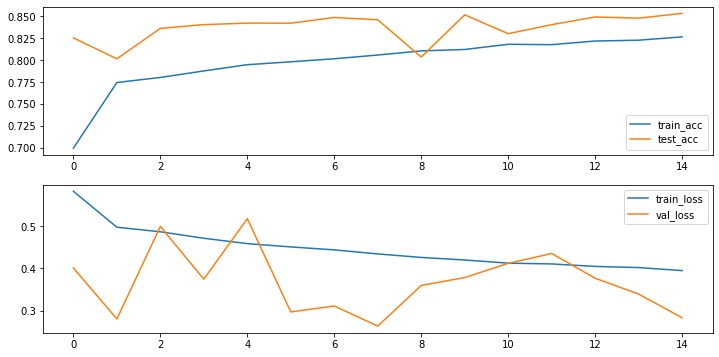

In [36]:
plt.figure(figsize = (12,6))
plt.subplot(2,1,1)
plt.plot(history2.history['acc'], label="train_acc")
plt.plot(history2.history['val_acc'], label = "test_acc")
plt.legend()
plt.subplot(2,1,2)
plt.plot(history2.history['loss'], label = "train_loss")
plt.plot(history2.history['val_loss'], label = "val_loss")
plt.legend()

In [37]:
pred = model.predict(x_test2)

In [38]:
res = []
for prediction in pred:
    if(prediction > 0.5):
        res.append(1)
    else:
        res.append(0)

In [39]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test2, res))
print(classification_report(y_test2, res))

[[9335  665]
 [2070 7930]]
              precision    recall  f1-score   support

           0       0.82      0.93      0.87     10000
           1       0.92      0.79      0.85     10000

    accuracy                           0.86     20000
   macro avg       0.87      0.86      0.86     20000
weighted avg       0.87      0.86      0.86     20000



In [42]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [45]:
dict_characters = {0: 'IDC(-)', 1: 'IDC(+)'}

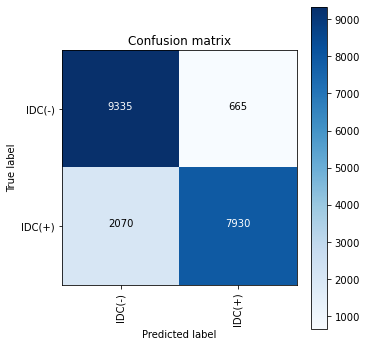

In [47]:
from sklearn.metrics import confusion_matrix, make_scorer, accuracy_score
import itertools
confusion_mtx = confusion_matrix(y_test2, res) 
plot_confusion_matrix(confusion_mtx, classes = list(dict_characters.values())) 
plt.show()

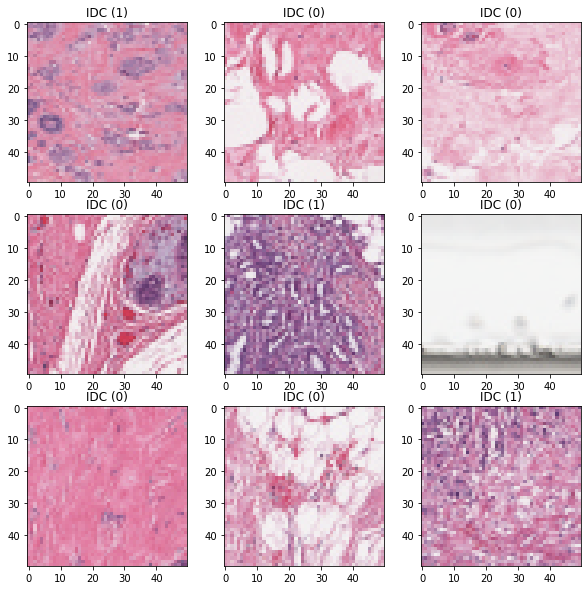

In [40]:

plt.figure(figsize= (10,10))
ind = np.random.randint(0, len(pred), 9)
i=0
for loc in ind:
    plt.subplot(3,3,i+1)
    plt.xlabel(None)
    plt.title("IDC ({})".format(res[loc]))
        
    plt.imshow(x_test2[loc])
    i+=1